<a href="https://colab.research.google.com/github/dbickson/UGATIT-pytorch/blob/master/examples/fastdup_image_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fastdup tutorial: 
In this tutorial we learn how to use fastdup to identify image anomalies and similar images on the food-101 dataset.

## Install fastdup

In [ ]:
pip install -U fastdup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.8 MB 1.3 MB/s 


## Download a sample dataset

In [ ]:
!gdown 1MPq6dSE5rGHCuNiW-4cAJL37JxJWYy_p


Downloading...
From: https://drive.google.com/uc?id=1MPq6dSE5rGHCuNiW-4cAJL37JxJWYy_p
To: /content/hamburger.zip
100% 50.0M/50.0M [00:00<00:00, 53.2MB/s]


In [ ]:
!unzip -qq hamburger.zip

replace food-101/images/hamburger/2836127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Run fastdup to compute image feature vectors and image statistics

In [ ]:
!rm -fr out
!python -c "import fastdup; fastdup.run('food-101/', work_dir='out',turi_param='ccthreshold=0.8')"

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
On Jupyter notebook running on large datasets, there may be delay getting the console output. We recommend running using python shell.
Going to loop over dir food-101/
Found total 1000 images to run on
Wrote total of 1000 features , found 0 bad images
Found total 1000 images to run on
312) Finished write_index() NN model
Stored nn model index file out/nnf.index
1659353589 : INFO:     (add_vertices:460): Num vertices for group 0: 1000
1659353589 : INFO:     (commit_edge_buffer:609): In commit edge buffer (0,0)
1659353589 : INFO:     (commit_edge_buffer:680): Shuffling edges ...
1659353589 : INFO:     (commit_edge_buffer:688): Done shuffling edges in 0.012306 secs
1659353589 : INFO:     (commit_edge_buffer:692): Aggregating unique vertices...
1659353589 : INFO:     (commit_edge_buffer:705): Done aggregating unique vertex in 0.001907 secs
1659353589 : INFO:     (commit_edge_buffer:713): Combine vertex data
16593535

Full documentation is found [here](https://visualdatabase.github.io/fastdup/).

# Find image outliers

In [ ]:
import fastdup
import os
# Create the outlier gallery.
# Note: get_reformat_filename_func() is an optional function to format the displayed filename, in this case we display just the filename without the full path.
#.      get_label_func() is an optional function to give the label.
fastdup.create_outliers_gallery('out','.',num_images=10,get_reformat_filename_func=lambda x: os.path.basename(x),get_label_func=lambda x: x.split('/')[-2])

100%|██████████| 10/10 [00:00<00:00, 117.64it/s]

Stored outliers visual view in  ./outliers.html



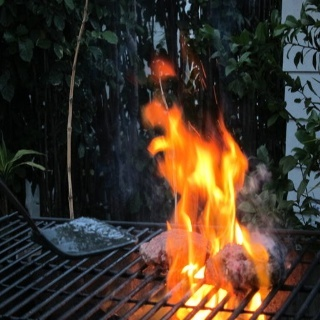
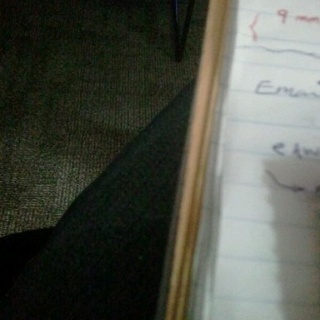
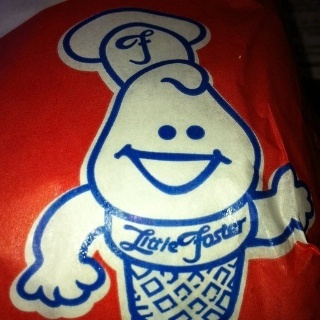
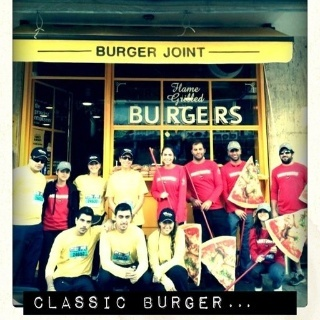
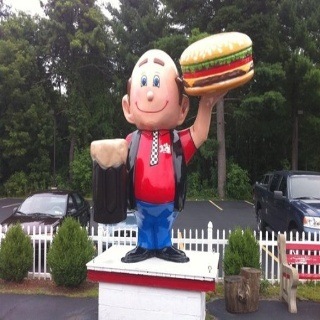
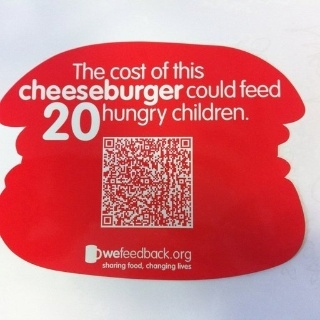
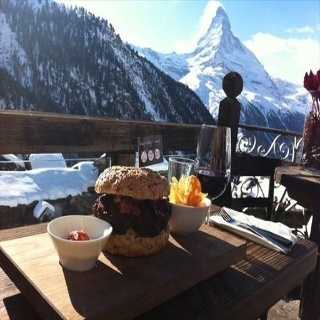
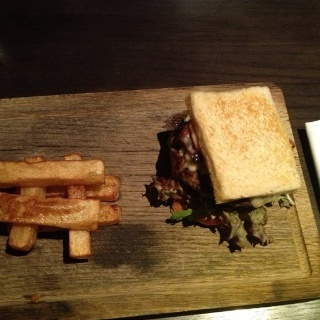
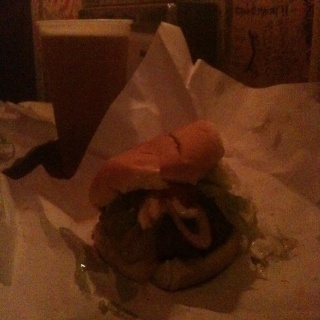
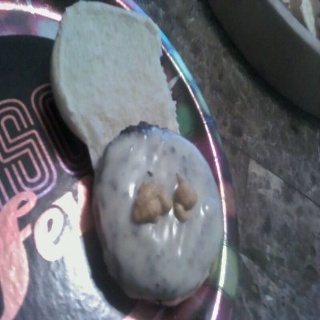

In [ ]:
from IPython.display import HTML
HTML('./outliers.html')

In [ ]:
import pandas as pd
import os
import numpy as np
from fastdup.image import *
from fastdup.galleries import visualize_top_components
from tqdm import tqdm


def visualize_top_components(work_dir, save_path, num_components, get_label_func=None, group_by='visual', slice=None,
                             get_bounding_box_func=None, max_width=None):
    '''
    Visualize the top connected components

    Args:
        work_dir (str): directory with the output of fastdup run
        num_components (int): number of top components to plot
        get_label_func (callable): option function to get label for each image given image filename
        group_by (str): 'visual' or 'label'
        slice (str): slice the datafrmae based on the label or a list of labels

    Returns:
        ret (pd.DataFrame): with the top components
        img_list (list): of the top components images
    '''

    try:
        from fastdup.tensorboard_projector import generate_sprite_image
        import traceback
    except Exception as ex:
        print('Your system is missing some depdencies, please pip install matplotlib matplotlib-inline torchvision')
        print(ex)
        return None, None

    assert os.path.exists(work_dir), "Failed to find work_dir " + work_dir
    assert num_components > 0, "Number of components should be larger than zero"

    MAX_IMAGES_IN_GRID = 48

    top_components = fastdup.galleries.do_find_top_components(work_dir=work_dir, get_label_func=get_label_func, group_by=group_by, slice=slice).head(num_components)
    if (top_components is None or len(top_components) == 0):
        print('Failed to find top components, try to reduce grouping threshold by running with turi_param="cchreshold=0.8" where 0.8 is an exmple value.')
        return None, None

    # iterate over the top components
    index = 0
    img_paths = []
    for i,row in tqdm(top_components.iterrows(), total = len(top_components)):
        try:
            # find the component id
            component_id = row['component_id']
            # find all the image filenames linked to this id
            files = row['files'][:MAX_IMAGES_IN_GRID]
            if (len(files) == 0):
                break

            tmp_images = []
            w,h = [], []
            for f in files:
                try:
                    img = cv2.imread(f)
                    img = plot_bounding_box(img, get_bounding_box_func, f)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    tmp_images.append(img)
                    w.append(img.shape[1])
                    h.append(img.shape[0])
                except Exception as ex:
                    print("Warning: Failed to load image ", f, "skipping image due to error", ex)

            if len(tmp_images) == 0:
                print("Failed to read all images")
                return None, None

            avg_h = int(np.mean(h))
            avg_w = int(np.mean(w))
            images = []
            for f in tmp_images:
                f = cv2.resize(f, (avg_w,avg_h))
                images.append(f)

            if len(images) <= 3:
                img, labels = generate_sprite_image(images,  len(images), '', None, h=avg_h, w=avg_w, alternative_width=len(images), max_width=max_width)
            else:
                img, labels = generate_sprite_image(images,  len(images), '', None, h=avg_h, w=avg_w, max_width=max_width)

            local_file = os.path.join(save_path, 'component_' + str(i) + '.jpg')
            cv2.imwrite(local_file, img)
            img_paths.append(local_file)
            index+=1


        except ModuleNotFoundError as ex:
            print('Your system is missing some dependencies please install then with pip install: ', ex)
            traceback.print_exc()
            return None, None

        except Exception as ex:
            print('Failed on component', i, ex)
            traceback.print_exc()
            return None, None

    print(f'Finished OK. Components are stored as image files {save_path}/componentsXX.jpg')
    return top_components.head(num_components), img_paths

def do_create_components_gallery(work_dir, save_path, num_images=20, lazy_load=False, get_label_func=None,
                                 group_by='visual', slice=None, max_width=None, max_items=None,
                                 get_bounding_box_func=None, get_reformat_filename_func=None, get_extra_info_func=None):
    '''

    Function to create and display a gallery of images for the largest graph components

    Parameters:
        work_dir (str): path to fastdup work_dir

        save_path (str): output folder location for the visuals

        num_images(int): Max number of images to display (default = 50). Be careful not to display too many images at once otherwise the notebook may go out of memory.

        lazy_load (boolean): If False, write all images inside html file using base64 encoding. Otherwise use lazy loading in the html to load images when mouse curser is above the image (reduced html file size).

        get_label_func (callable): optional label string, given a absolute path to an image return the label for the html report

        group_by (str): [visual|label]. Group the report using the visual properties of the image or using the labels of the images. Default is visual.

        slice(str): optional label to draw only a subset of the components conforming to this label. Or a list of labels.

        max_width (int): optional parameter to control resulting html width. Default is None

        max_items (int): optional parameter to control th number of items displayed in statistics: top max_items labels (for group_by='visual')
            or top max_items components (for group_by='label'). Default is None namely show all items.

        get_bounding_box_func (callable): optional function to get bounding box of an image and add them to the report

        get_reformat_filename_func (callable): optional function to reformat the filename to be displayed in the report

        get_extra_col_func (callable): optional function to get extra column to be displayed in the report



     '''
    assert os.path.exists(work_dir), "Failed to find work_dir " + work_dir
    if num_images > 1000 and not lazy_load:
        print("When plotting more than 1000 images, please run with lazy_load=True. Chrome and Safari support lazy loading of web images, otherwise the webpage gets too big")
    if not os.path.exists(save_path):
        os.mkdir(save_path)
        if not os.path.exists(save_path):
            print(f"Failed to generate save_path directory {save_path}")
            return None

    assert num_images >= 1, "Please select one or more images"
    assert group_by == 'label' or group_by == 'visual', "Allowed values for group_by=[visual|label], got " + group_by
    if group_by == 'label':
        assert callable(get_label_func), "missing get_label_func, when grouping by labels need to set get_label_func"


    subdf, img_paths = visualize_top_components(work_dir, save_path, num_images, get_label_func, group_by, slice, get_bounding_box_func, max_width)
    if subdf is None or len(img_paths) == 0:
        return None

    assert len(subdf) == len(img_paths), "Number of components and number of images do not match"

    import fastdup.html_writer
    if 'labels' in subdf.columns:
    	ret2 = pd.DataFrame({'component_id':subdf['component_id'].values,
        	                 'num_images':subdf['len'].apply(lambda x: "{:,}".format(x)).values,
                	         'labels': subdf['labels']})
    else:
    	ret2 = pd.DataFrame({'component_id':subdf['component_id'].values,
        	                 'num_images':subdf['len'].apply(lambda x: "{:,}".format(x)).values})
 
    info_list = []
    for i,row in ret2.iterrows():
        if group_by == 'visual':
            comp = row['component_id']
            num = row['num_images']
            info_df = pd.DataFrame({'component':[comp], 'num_images':[num]}).T
            info_list.append(info_df.to_html(escape=True, header=False).replace('\n',''))
        elif group_by == 'label':
            label = row['labels']
            num = row['num_images']
            info_df = pd.DataFrame({'label':[label], 'num_images':[num]}).T
            info_list.append(info_df.to_html(escape=True, header=False).replace('\n',''))
    ret = pd.DataFrame({'info': info_list})

    if 'labels' in subdf.columns:
        if group_by == 'visual':
            labels_table = []
            for i,row in subdf.iterrows():
                unique, counts = np.unique(np.array(row['labels']), return_counts=True)
                lencount = len(counts)
                if max_items is not None and max_items < lencount:
                    lencount = max_items;
                counts_df = pd.DataFrame({"counts":counts}, index=unique).sort_values('counts', ascending=False).head(lencount).to_html(escape=False).replace('\n','')
                labels_table.append(counts_df)
            ret.insert(0, 'labels', labels_table)
        else:
            comp_table = []
            for i,row in subdf.iterrows():
                unique, counts = np.unique(np.array(row['component_id']), return_counts=True)
                lencount = len(counts)
                if max_items is not None and max_items < lencount:
                    lencount = max_items;
                counts_df = pd.DataFrame({"counts":counts}, index=unique).sort_values('counts', ascending=False).head(lencount).to_html(escape=False).replace('\n','')
                comp_table.append(counts_df)
            ret.insert(0, 'components', comp_table)

    if not lazy_load:
        ret.insert(0, 'image', [imageformatter(x, max_width) for x in img_paths])
    else:
        img_paths2 = ["<img src=\"" + os.path.join(save_path, os.path.basename(x)) + "\" loading=\"lazy\">" for x in img_paths]
        ret.insert(0, 'image', img_paths2)

    out_file = os.path.join(save_path, 'components.html')
    columns = ['info','image']
    if 'labels' in subdf.columns:
        if group_by == 'visual':
            columns.append('labels')
        elif group_by == 'label':
            columns.append('components')



    title = 'Fastdup Tool - Components Report'
    if slice is not None:
        title += ", " + str(slice)
    fastdup.html_writer.write_to_html_file(ret[columns], 'Fastdup Tool - Components Report', out_file)
    assert os.path.exists(out_file), "Failed to generate out file " + out_file

    print("Stored components visual view in ", os.path.join(out_file))
    if not lazy_load:
        for i in img_paths:
            try:
                os.unlink(i)
            except Exception as e:
                print("Warning, failed to remove image file ", i, " with error ", e)





In [ ]:
do_create_components_gallery('out','.',num_images=10,get_reformat_filename_func=lambda x: os.path.basename(x),get_label_func=lambda x: x.split('/')[-2], max_width=500)

100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Finished OK. Components are stored as image files ./componentsXX.jpg
Stored components visual view in  ./components.html



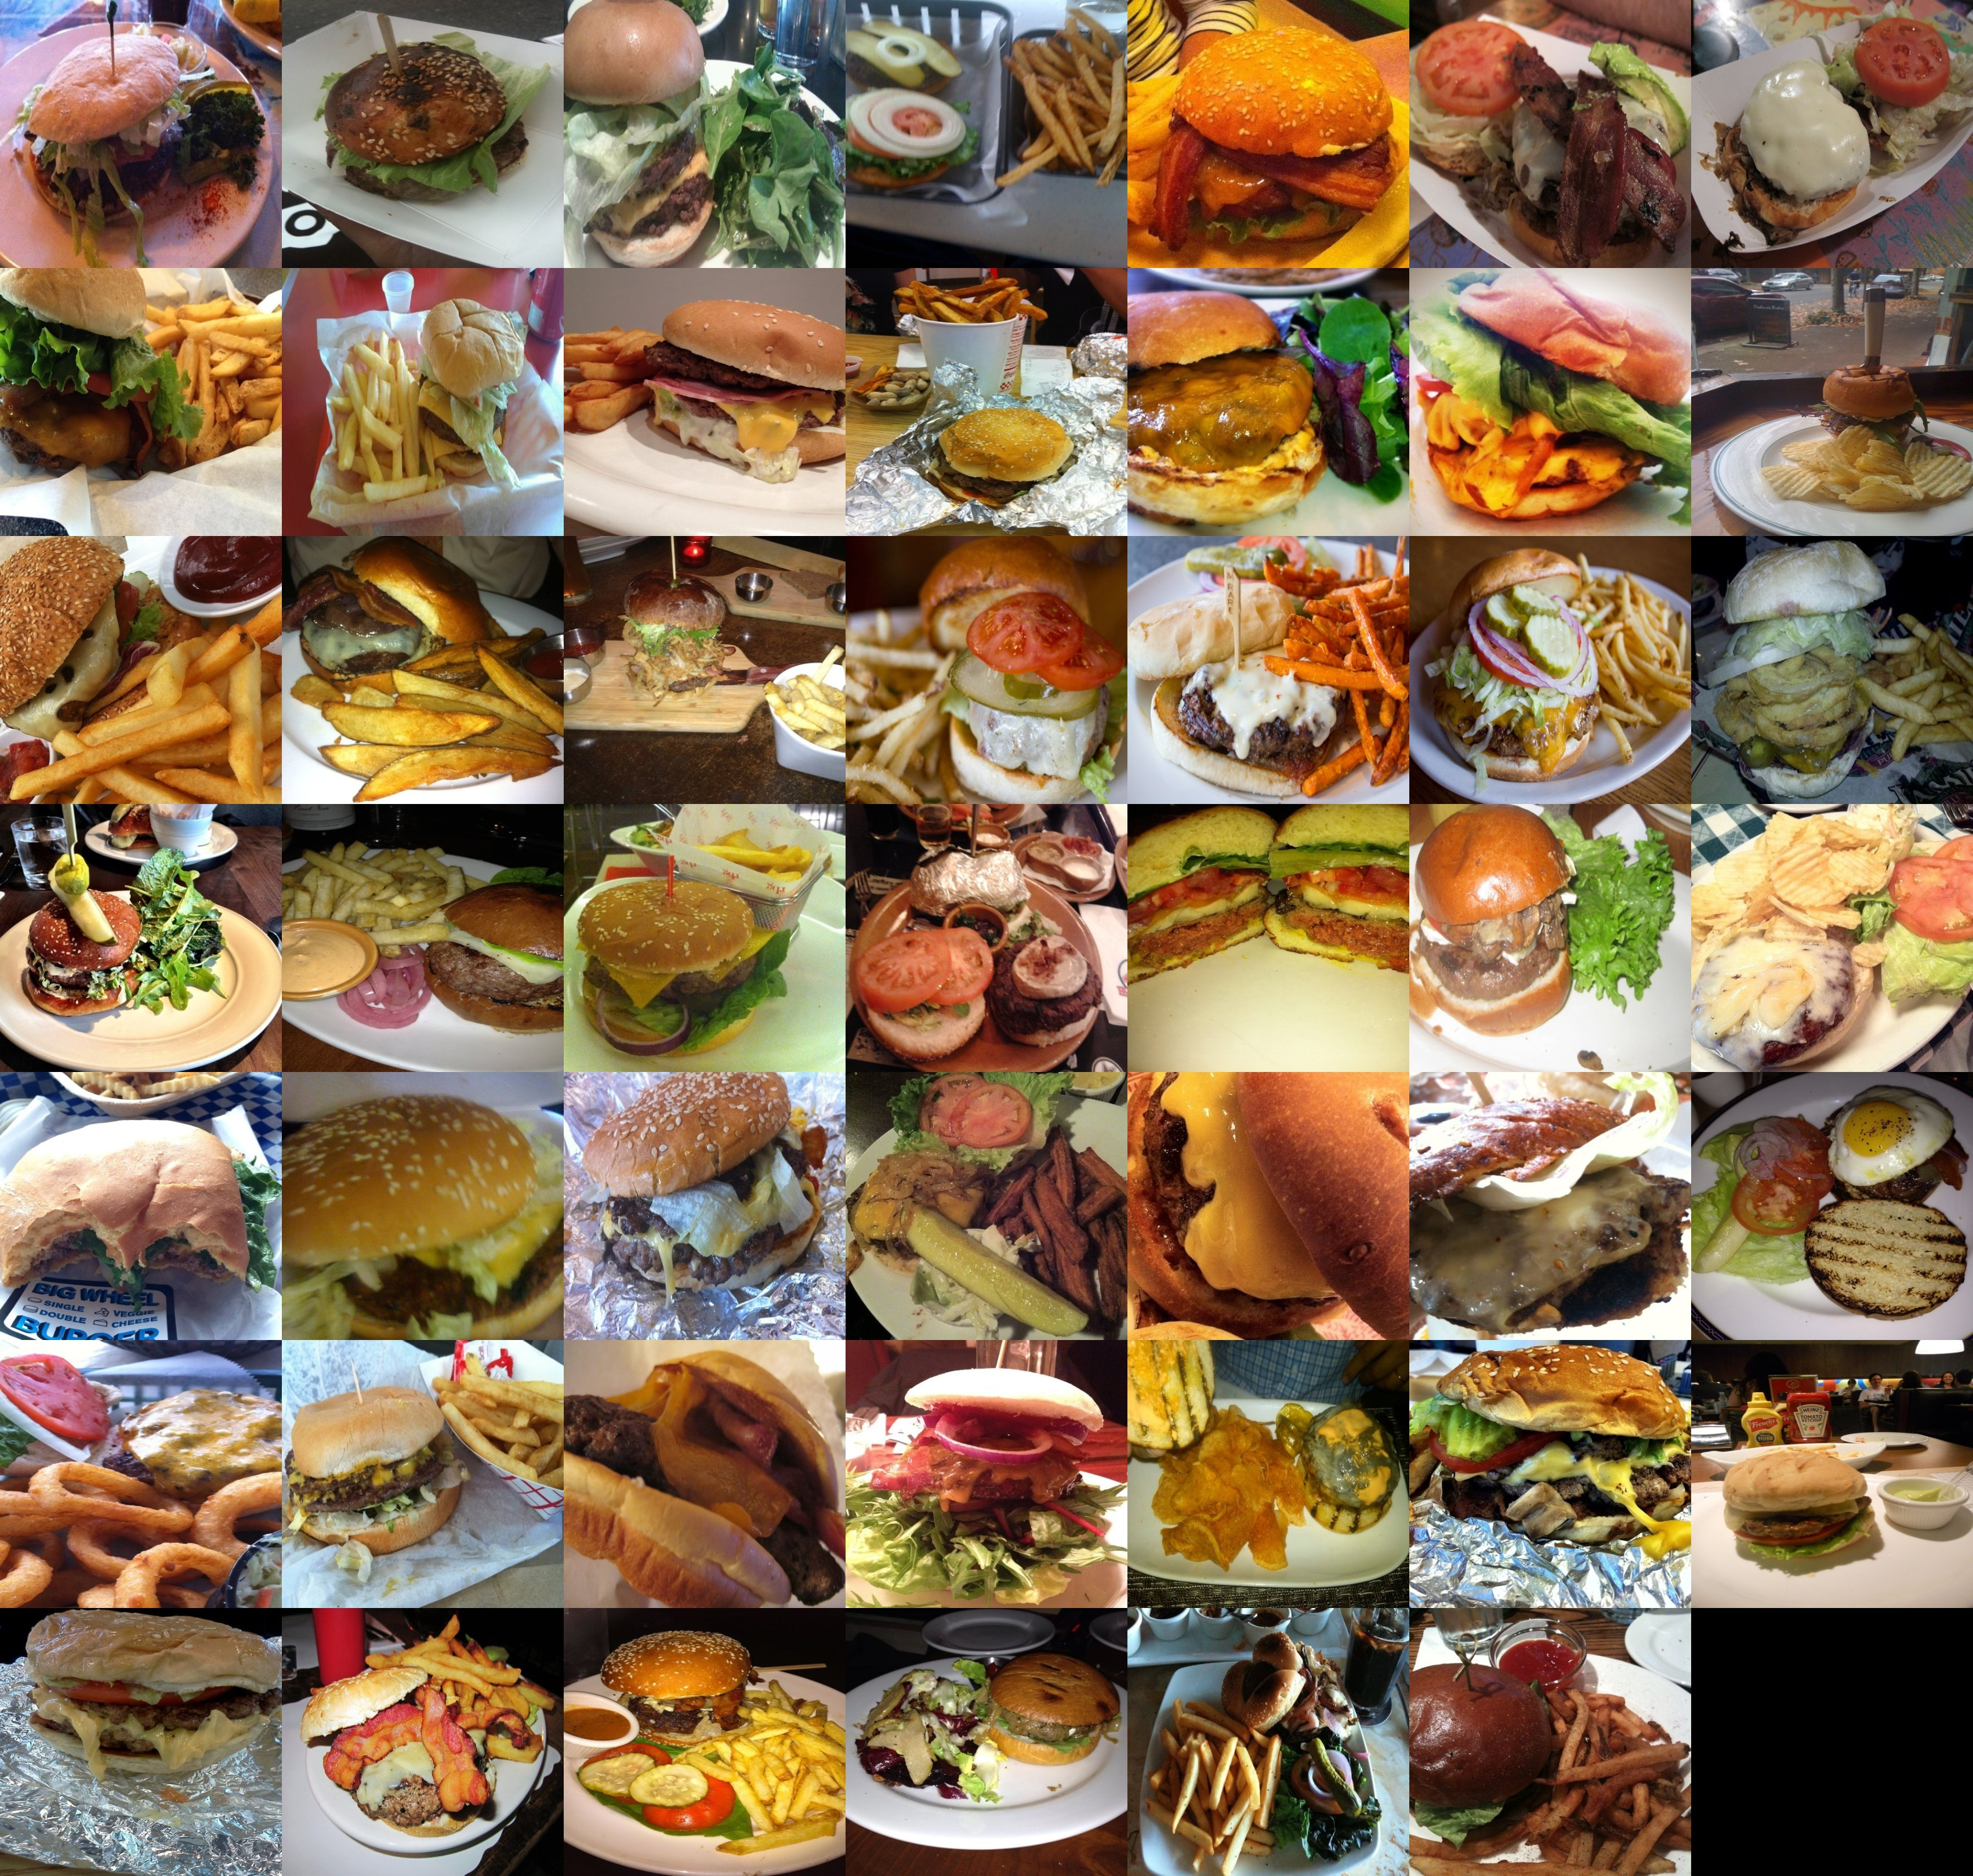
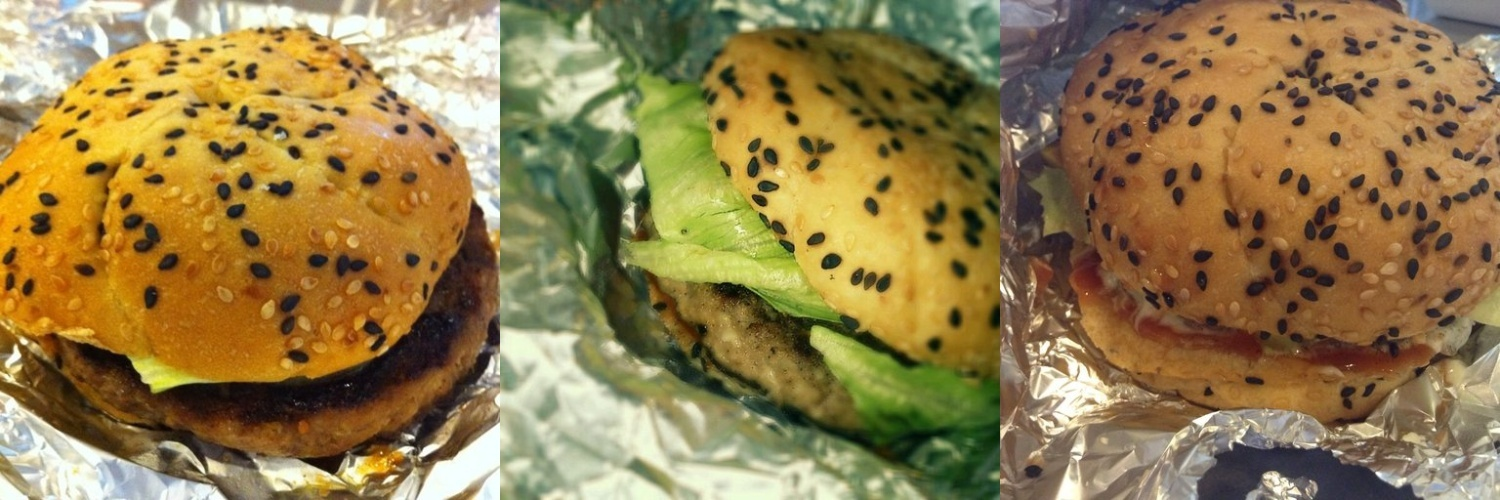
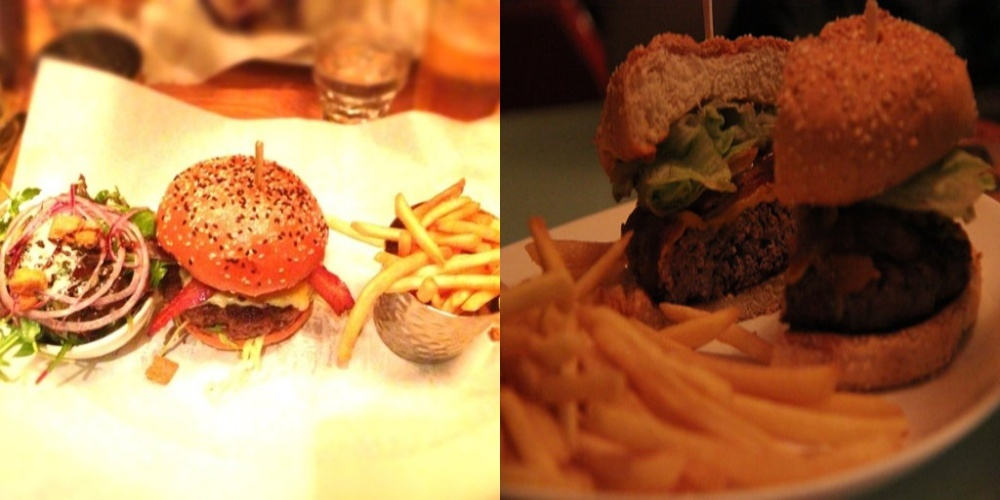
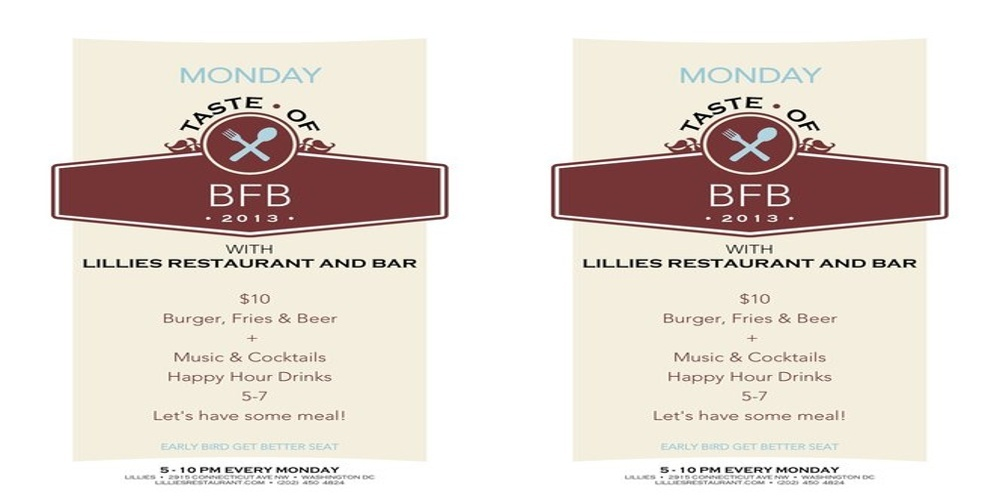

In [ ]:
HTML('./components.html')